In [1]:
import numpy as np # math
from scipy.interpolate import interp1d # interpolation 1d
from scipy.stats import norm # normal distribution
import matplotlib.pyplot as plt # graphs and plots
import pandas as pd
import datetime
import matplotlib.dates as mdates

In [4]:
# import of the excel with the show up profiles
show_up_ter = pd.read_excel(
    r"/home/antoine/projects/KAPpaxsim/KAPpaxsim/data/raw/ADRM_param_full.xlsx",
    sheet_name=r"terminal",
    header=1,
)

show_up_ter = show_up_ter.drop([0, 1], axis=0)
show_up_ter = show_up_ter.reset_index(drop=True)

In [5]:
show_up_ter.head()

,time before STD,cumulative distribution FSC,cumulative distribution LCC,cumulative distribution EARLY,cumulative distribution CHINA,Unnamed: 5,density distribution FSC
0,0,1.000000,1.000000,1.000000,1.000000,NaN,0.000000
1,5,0.995940,0.996565,0.999217,0.998726,NaN,0.000177
2,10,0.994967,0.995668,0.998765,0.998304,NaN,0.000214
3,15,0.993790,0.994565,0.998085,0.997759,NaN,0.000258
4,20,0.992377,0.993221,0.997081,0.997060,NaN,0.000309


In [6]:
# interpolation of show_up profiles and inverse functions
x = show_up_ter["time before STD"].to_numpy(dtype=float)

In [7]:
flight_types = ['FSC',"LCC","EARLY","CHINA"]

dct_y = {
    flight_type : show_up_ter["cumulative distribution {}".format(flight_type)] for flight_type in flight_types
}

In [8]:
dct_f_ter = {
    flight_type : interp1d(x, dct_y[flight_type], kind="linear") for flight_type in flight_types
}

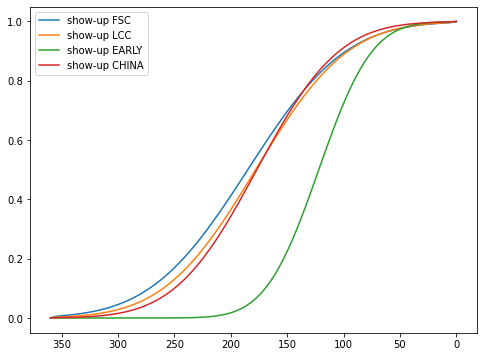

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
x = np.linspace(0, 360, 100)

for key in dct_f_ter:
    ax.plot(x, dct_f_ter[key](x), label="show-up {}".format(key))

ax.invert_xaxis()

ax.legend()
# ax.set(xlim=(0, 360), ylim=(0, 1))
plt.show()

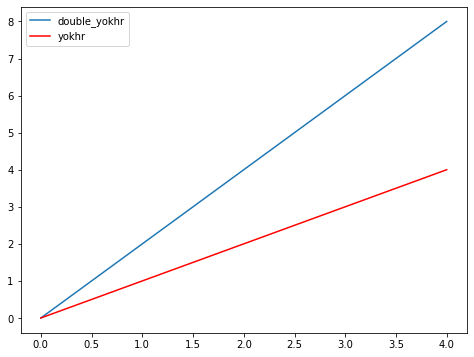

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot([0,1,2,3,4],[0,2,4,6,8], label="double_yokhr")
ax.plot([0,1,2,3,4],[0,1,2,3,4], label="yokhr",color="red")


plt.legend()

In [11]:
dct_f_ter

{'FSC': <scipy.interpolate.interpolate.interp1d at 0x7f1d1f202ea0>,
 'LCC': <scipy.interpolate.interpolate.interp1d at 0x7f1d1f214590>,
 'EARLY': <scipy.interpolate.interpolate.interp1d at 0x7f1d1f7ab040>,
 'CHINA': <scipy.interpolate.interpolate.interp1d at 0x7f1d1efef900>}

In [12]:
dct_f_ter_inv = {flight_type : interp1d(dct_f_ter[flight_type](x), x, kind="linear") for flight_type in flight_types }

In [16]:
from src.utils.profiles_from_schedule_new import show_up_generator, Schedule # class for show-up generator
test = Schedule()
path_to_6k_sched = r"/home/antoine/projects/KAPpaxsim/KAPpaxsim/data/processed/Schedule (30th terminal peak, 6000 pax)_PROCESSED.xlsx"
test.from_path(path=path_to_6k_sched)
test.cleanup()
test.filter()

In [18]:
# only FSC flights
# our schedule is stored in test.data

# we need a column "show_up_category" in the schedule dataframe
list_time_Pax = []
list_flights = []
list_ST = []
list_category = []

# I want to create a table like:
#     "Flight Number"
#     "time": pax show-up time
#     "Scheduled Time": flight STD
#     "Category": type (eg. early, china. fsc, LCC)

In [20]:
test.schedule.head(n=1)

,index,Unnamed: 0,A/D,T1/T2(MM/9C/7C/TW),Intl Regions,Category(P/C/O),Sector,Flight Number,SEATS FC,PAX_SUM FC,Flight Date,Scheduled Time,datetime
0,263,263,D,T1,unknown,P,I,TAX 611,377,323.95,2017-03-19,2020-10-13 00:10:00,2017-03-19 00:10:00


In [21]:
test.schedule['PAX_SUM FC'].replace('-',0,inplace=True)

In [22]:
# important: boolean indexing on DataFrames
mask_LCC = test.airline_code["FSC / LCC"] == "LCC"
test.airline_code[mask_LCC]

AttributeError: 'Schedule' object has no attribute 'airline_code'

In [ ]:
test.data.head(n=2)

In [ ]:
# let's define flight categories
# first check if early
# then check if china
# then check if LCC
# else, its FSC

# first, let's prepare lists of LCC
list_LCC = test.airline_code[mask_LCC]["airline code"].to_numpy(dtype="str")

# loop through schedule and test with if condtions

for i in range(len(test.data)):
    std =test.data.loc[i, "Scheduled Time"]
    if std < pd.to_datetime(
                "2020-10-13 08:00:00"
            ) and std >= pd.to_datetime(
                "2020-10-13 02:00:00"
            ):
        category = "EARLY"

    elif test.data.loc[i, "Intl Regions"] == "China":
        category = "China"

    elif test.data.loc[i, "Flight Number"][0:2] in list_LCC:
        category = 'LCC'

    else:
        category = "FSC"

    test.data.loc[i,"show_up_category"] = category



In [ ]:

# loop trhough each flight (= line of flight schedule)
for i in range(len(test.data)):
    N_flight_pax = int(test.data.loc[i, "PAX_SUM FC"])
    std = test.data.loc[i, "Scheduled Time"]
    show_up_category = test.data.loc[i,"show_up_category"]
    flight_number = test.data.loc[i, "Flight Number"]

    y = np.linspace(0.0001, 0.995, N_flight_pax)
    f_ter_inv_linear = dct_f_ter_inv[show_up_category]

    time_Terminal = ( 
        std.hour * 60
        + std.minute
        - f_ter_inv_linear(y)
    )

    for t in time_Terminal:
        t = datetime.datetime(
            year=2020,
            month=10,
            day=13,
            hour=int((t % (24 * 60)) / 60),
            minute=int(t % 60),
            second=int(t % 1 * 60),
        )
        list_time_Pax.append(t)
        list_flights.append(flight_number)
        list_ST.append(std)
        list_category.append(show_up_category)


In [ ]:

dct_Pax = {
    "Flight Number": list_flights,
    "time": list_time_Pax,
    "Scheduled Time": list_ST,
    "Category": list_category,
}
df_Pax = pd.DataFrame(dct_Pax)

In [ ]:
df_Pax['Pax']=1

In [ ]:
plot = (
    df_Pax.set_index("time", drop=False)["Pax"]
    .resample("5min")
    .agg(["sum"])
    .rolling(window=12, center=True)
    .mean()
    .dropna()
)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(plot * 12, label="total show-up")

# plot param
xmin = pd.to_datetime("2020-10-13 00:00:00")
xmax = pd.to_datetime("2020-10-14 00:00:00")
plt.rcParams.update({"figure.autolayout": True})
hours = mdates.HourLocator(interval=1)
half_hours = mdates.MinuteLocator(byminute=[0, 30], interval=1)
h_fmt = mdates.DateFormatter("%H:%M")

# formatting
ax.set_xlim((xmin, xmax))
ax.set_xticks(plot.index.to_list())
ax.set_xticklabels(ax.get_xticks(), rotation=45, **{"horizontalalignment": "right"})
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
ax.xaxis.set_minor_locator(half_hours)
ax.legend(loc="upper left", frameon=False)

plt.show()
